# Filtering and normalisation

We have to import all libraries and load up the scanpy file from the previous step

In [1]:
import numpy as np
import pandas
import scanpy as sc
import anndata
import json
import matplotlib.pyplot as plt
import scvelo as scv
import os
import requests
import shutil
%matplotlib inline

/home/picrin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
adata = anndata.read_h5ad(os.path.join("data", "00_bile_duct_cancer.h5ad"))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


First, let's make all gene names unique

In [3]:
old_names = set(adata.var_names)

In [4]:
adata.var_names_make_unique()

In [5]:
new_names = set(adata.var_names)

Inspection of gene names suggests that most genes requiring disambiguation are small non-coding RNAs. This could be a by-product of our alignment pipeline, but given that we're mostly interested in mRNA, this shouldn't be a big issue for our analysis.

In [6]:
list(new_names - old_names)[:10]

['RF00019-380',
 'SNORA50B-1',
 'RF00017-131',
 'RF00561-10',
 'RF00019-213',
 'RF00019-447',
 'RF00019-8',
 'RF00003-13',
 'RF00017-87',
 'RF00019-375']

In [7]:
len(new_names - old_names)

1543

The first thing we can learn about cancer cells in our dataset is the total count of RNA moleclues (often referred to as UMI)

In [8]:
UMI_count = adata.X.sum(1)

In [9]:
UMI_count

matrix([[ 1474.],
        [ 3058.],
        [16258.],
        ...,
        [ 2949.],
        [ 1871.],
        [ 1710.]], dtype=float32)

In [10]:
UMI_count.shape

(2104, 1)

In [11]:
counts = np.ravel(UMI_count)
counts.shape

(2104,)

In [12]:
adata.obs["n_counts"] = counts

We can visualise our newly computed information about cells using a violin plot

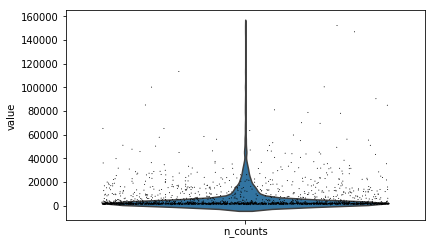

In [13]:
sc.pl.violin(adata, ['n_counts'], jitter=0.4)

Very highly expressed cells are likely doublets or triplets or some other types of artifacts. We can filter out, say 5% of most expressed cells.

In [14]:
cutoff = sorted(counts)[int(len(counts)*0.95)]

In [15]:
adata = adata[adata.obs['n_counts'] < cutoff, :]

We can visualise our data again

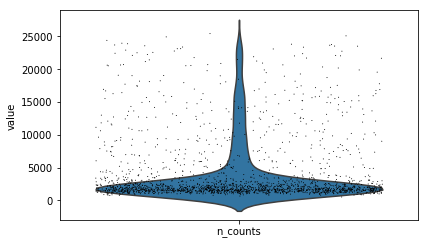

In [16]:
sc.pl.violin(adata, ['n_counts'], jitter=0.4)

Lowly expressed cells are also a concern -- these can indicate ruptured or apoptotic cell remnants. Earlier stages of the pipeline have already filtered some of these cells, but we should still be cautions.

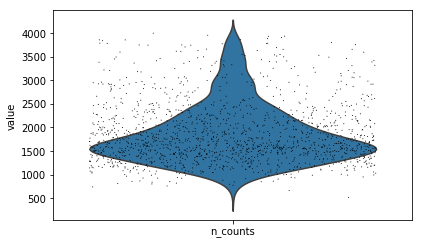

In [17]:
sc.pl.violin(adata[adata.obs["n_counts"] < 4000, : ], ['n_counts'], jitter=0.4)

As we can see, very few cells are expressed at a level of 1000 UMI or below. Given that these cells are most likely low quality/ ruptured/ apoptotic we can filter them out.

In [18]:
adata = adata[adata.obs["n_counts"] > 1000, :]

In [19]:
adata.shape

(1963, 58395)

We can also look at most highly expressed genes.

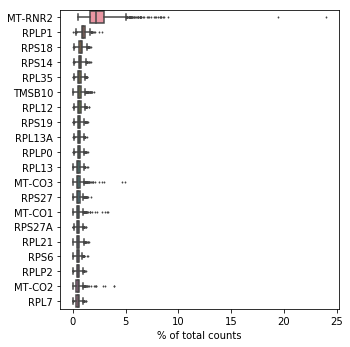

In [20]:
sc.pl.highest_expr_genes(adata, n_top=20)

As we can see, the list contains a lot of mitochondrial genes ("MT-"). This can be a cause of concern, as this can be indicative of a high proportion of ruptured cells. Previous studies using healthy tissue have filtered out cells with more than 5% mitochondrial RNA.

Let's first identify mitochondrial genes

In [21]:
mito_genes = adata.var_names.str.startswith('MT-')

And compute their percentage

In [22]:
adata.obs["percent_mito"] = np.ravel(np.sum(adata[:, mito_genes].X, axis=1)) / adata.obs["n_counts"]

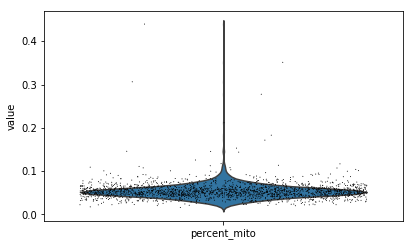

In [23]:
sc.pl.violin(adata, ['percent_mito'], jitter=0.4)

As can be seen in the plot, rejecting all cells with more than 5% mitochondrial RNA would significantly reduce our sample. However, given that these are cancer cells, and mitochondrial function is [known to be dirupted](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4371788/) in cancer, we will adjust the usual threshold to 10%.

In [24]:
adata = adata[adata.obs['percent_mito'] < 0.1, :]

In [25]:
adata

View of AnnData object with n_obs × n_vars = 1937 × 58395 
    obs: 'n_counts', 'percent_mito'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

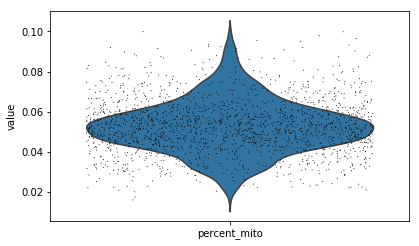

In [26]:
sc.pl.violin(adata, ['percent_mito'], jitter=0.4)

Next, we can filter out cells which express few genes, and filter out genes which are present in only small number of cells. We will save the original list of genes separately to allow for investigation even after reduction of the number of genes.

In [27]:
sc.pp.filter_cells(adata, min_genes=200) # 200
genes_accessions = adata.var["Accession"]
adata.uns['before_filter_rare_genes'] = list(genes_accessions.index), list(genes_accessions)
sc.pp.filter_genes(adata, min_cells=100) # 100

In [28]:
adata.X.eliminate_zeros() # Removes explicit zeros
n_genes = adata.X.getnnz(axis=1) # Counts explicit values

# or, slightly less efficient but still more efficient than making a dense array
#np.ravel((adata.X != 0).sum(axis=1))

In [29]:
n_genes

array([ 814, 1410, 3580, ..., 1387, 1007,  874], dtype=int32)

These filters compute an addition observation, `n_genes` (and an additional column `n_columns`). This is all that we've managed to learn about our cells so far.

In [30]:
adata.obs[:10]

,n_counts,percent_mito,n_genes
index,,,
correct_result_9QWIF:AATCCTACATATx,1474.0,0.046133,869
correct_result_9QWIF:AAATGTAAGACTx,3058.0,0.045782,1513
correct_result_9QWIF:AAGCAGGTGCTTx,16258.0,0.033583,4058
correct_result_9QWIF:AAACACCAGCATx,16410.0,0.096527,4251
correct_result_9QWIF:AAGCTCATGCGGx,3250.0,0.092615,1580
correct_result_9QWIF:AAGTGATTGGAGx,1566.0,0.047254,908
correct_result_9QWIF:AATCGCTGTTTTx,1347.0,0.069785,840
correct_result_9QWIF:AACGGGTTCGTGx,6427.0,0.055236,2458
correct_result_9QWIF:AAGCAAGTAACTx,1050.0,0.060952,695


Despite all the filtering, a number of gene counts is still a major source of variation, and given that the origin of this variation is believed to be mostly technical, and biologically uninteresting, we will attempt to remove it by rescaling total gene count in each cell to 10000

In [31]:
3000 * 2000

6000000

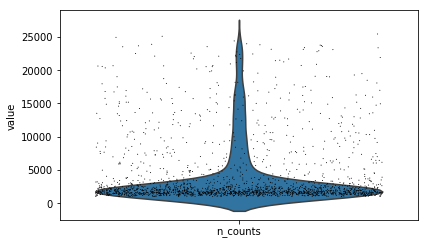

In [32]:
sc.pl.violin(adata, ['n_counts'], jitter=0.4)

In [33]:
before_normalising = adata.X.sum(1)

In [34]:
before_normalising

matrix([[ 1418.],
        [ 2952.],
        [15736.],
        ...,
        [ 2847.],
        [ 1820.],
        [ 1634.]], dtype=float32)

In [35]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

In [36]:
adata.X.sum(1)

matrix([[ 9999.999],
        [10000.   ],
        [10000.   ],
        ...,
        [10000.001],
        [10000.001],
        [ 9999.999]], dtype=float32)

Prior experience working with microarray and bulk RNA-seq data suggests that many effects are linear in the logarithm of the UMI count (or probe intensity, or read coverage), and it's therefore advised to log the data as part of the normalisation process.

In [37]:
sc.pp.log1p(adata)

In [38]:
adata.X.sum(1)

matrix([[1921.4962],
        [2541.3826],
        [3381.6453],
        ...,
        [2566.769 ],
        [2164.2646],
        [1977.629 ]], dtype=float32)

In [39]:
genes_accessions = adata.var["Accession"]
adata.uns['before_filter_nonvariable_genes'] = list(genes_accessions.index), list(genes_accessions)

One method to reduce dimensionality, employed also by Seurat and CellRanger software, computes dispersion, which is the ratio of variance and mean of (logged) genes across all cells. Highly variable genes can be identified based on this parameter, and selected for further analysis. Additionally, highly expressed genes are unlikely to be helpful in the analysis, as they most likely come from non-coding RNA, and we can also filter them out.

In [40]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

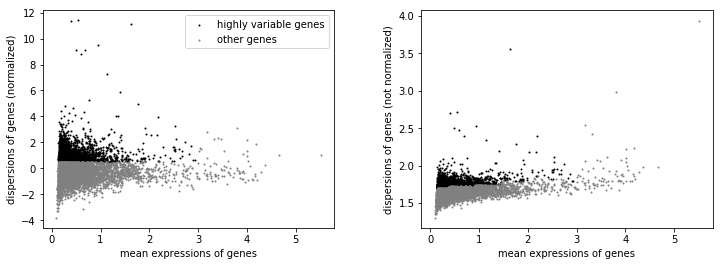

In [41]:
sc.pl.highly_variable_genes(adata)

In [42]:
adata = adata[:, adata.var['highly_variable']]

Gene variance on its own can be a source of unwanted signal in the data. All genes are scaled to unit variance and values exceeding std=10 can be clipped to extremes.

In [43]:
sc.pp.scale(adata, max_value=10)

In [44]:
after_normalising = adata.X.sum(1)

In [45]:
after_normalising

array([-114.175674,   57.49641 ,  377.21887 , ...,   31.574308,
        -41.30066 , -181.8916  ], dtype=float32)

In [46]:
#sc.pp.normalize_per_cell(adata, counts_per_cell_after=10)

In [47]:
adata.X.sum(1)

array([-114.175674,   57.49641 ,  377.21887 , ...,   31.574308,
        -41.30066 , -181.8916  ], dtype=float32)

In [48]:
import scipy.stats
scipy.stats.pearsonr(before_normalising.T.tolist()[0], after_normalising.T.tolist())

(0.8557014178981134, 0.0)

# Write to file

In [49]:
filepath = os.path.join("data", "01_bile_duct_cancer.h5ad")

In [50]:
adata.write(filepath)

# What to read next

The next notebook `02_stemness_analysis.ipynb` carries out the actual single cell analysis.